In [16]:
# Cell 1: Install and import dependencies
import os
%pip install nibabel torch matplotlib --quiet
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Cell 2: Dataset class
class ISLESDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")
                    dwi_path = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    flair_path = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]
                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]
                    if dwi_path and flair_path and mask_path:
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_path[0]),
                            "flair": os.path.join(anat_dir, flair_path[0]),
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi = nib.load(sample["dwi"]).get_fdata()
        flair = nib.load(sample["flair"]).get_fdata()
        mask = nib.load(sample["mask"]).get_fdata()
        # Crop to minimum shape
        min_shape = np.min([dwi.shape, flair.shape, mask.shape], axis=0)
        dwi = dwi[:min_shape[0], :min_shape[1], :min_shape[2]]
        flair = flair[:min_shape[0], :min_shape[1], :min_shape[2]]
        mask = mask[:min_shape[0], :min_shape[1], :min_shape[2]]
        # Normalize and stack channels
        dwi = (dwi - dwi.mean()) / (dwi.std() + 1e-5)
        flair = (flair - flair.mean()) / (flair.std() + 1e-5)
        x = np.stack([dwi, flair], axis=0).astype(np.float32)
        y = (mask > 0).astype(np.float32)
        return torch.tensor(x), torch.tensor(y)


In [18]:
# Cell 3: Simple 3D CNN model
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 8, 3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv3d(16, 1, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x.squeeze(1)


In [19]:

# Cell 4: Training function
def train_model(data_folder, model_save_path, epochs=2, batch_size=1):
    dataset = ISLESDataset(data_folder)
    if len(dataset) == 0:
        print("No samples found. Please check your data structure and mask file names.")
        return
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = Simple3DCNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        for i, (inputs, targets) in enumerate(loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.4f}")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")


In [20]:
# Cell 5: Train and save 3 models for ensemble
for i in range(1, 4):
    train_model('data', f"model{i}.pth", epochs=2, batch_size=1)


Total samples found: 20


Epoch 1, Batch 1, Loss: 0.7879
Epoch 1, Batch 2, Loss: 0.7650
Epoch 1, Batch 3, Loss: 0.7489
Epoch 1, Batch 4, Loss: 0.7434
Epoch 1, Batch 5, Loss: 0.7273
Epoch 1, Batch 6, Loss: 0.7038
Epoch 1, Batch 7, Loss: 0.6791
Epoch 1, Batch 8, Loss: 0.6290
Epoch 1, Batch 9, Loss: 0.6312
Epoch 1, Batch 10, Loss: 0.6135
Epoch 1, Batch 11, Loss: 0.5960
Epoch 1, Batch 12, Loss: 0.5376
Epoch 1, Batch 13, Loss: 0.5433
Epoch 1, Batch 14, Loss: 0.5037
Epoch 1, Batch 15, Loss: 0.4879
Epoch 1, Batch 16, Loss: 0.4381
Epoch 1, Batch 17, Loss: 0.4804
Epoch 1, Batch 18, Loss: 0.3908
Epoch 1, Batch 19, Loss: 0.3486
Epoch 1, Batch 20, Loss: 0.3136
Epoch 2, Batch 1, Loss: 0.3143
Epoch 2, Batch 2, Loss: 0.2602
Epoch 2, Batch 3, Loss: 0.2700
Epoch 2, Batch 4, Loss: 0.2377
Epoch 2, Batch 5, Loss: 0.2594
Epoch 2, Batch 6, Loss: 0.1202
Epoch 2, Batch 7, Loss: 0.2349
Epoch 2, Batch 8, Loss: 0.1273
Epoch 2, Batch 9, Loss: 0.1744
Epoch 2, Batch 10, Loss: 0.1096
Epoch 2, Batch 11, Loss: 0.0884
Epoch 2, Batch 12, Loss: 0

In [21]:

# Cell 6: Ensemble model class
class EnsembleSegmentationModel(nn.Module):
    def __init__(self, model_list):
        super().__init__()
        self.models = nn.ModuleList(model_list)
    def forward(self, x):
        preds = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                preds.append(model(x))
        preds_stack = torch.stack(preds, dim=0)
        ensemble_pred = torch.mean(preds_stack, dim=0)
        return ensemble_pred


In [22]:

# Cell 7: Load models utility
def load_models(model_paths):
    models = []
    for path in model_paths:
        model = Simple3DCNN()
        model.load_state_dict(torch.load(path, map_location="cpu"))
        model.eval()
        models.append(model)
    return models


In [23]:
# Cell 8: Predict and show ensemble output
def predict_and_show_ensemble(data_folder, model_paths, idx=0, slice_idx=None):
    dataset = ISLESDataset(data_folder)
    if len(dataset) == 0:
        print("No samples found.")
        return
    models = load_models(model_paths)
    ensemble_model = EnsembleSegmentationModel(models)
    x, y = dataset[idx]
    x = x.unsqueeze(0)
    with torch.no_grad():
        pred = ensemble_model(x)
    pred_np = pred.squeeze().numpy()
    flair_np = x[0,1].numpy()
    mask_np = y.numpy()
    if slice_idx is None:
        slice_idx = flair_np.shape[2] // 2
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("FLAIR")
    plt.imshow(flair_np[:,:,slice_idx], cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_np[:,:,slice_idx], cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Ensemble Predicted Mask")
    plt.imshow(pred_np[:,:,slice_idx], cmap='gray')
    plt.axis('off')
    plt.show()


Total samples found: 20


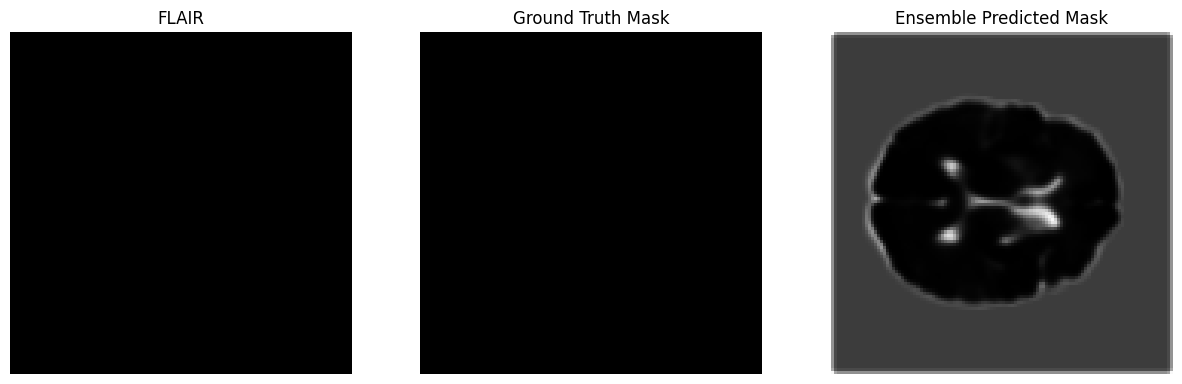

In [24]:

# Cell 9: Run ensemble prediction
predict_and_show_ensemble('data', ['model1.pth', 'model2.pth', 'model3.pth'], idx=0)